# Import Dependencies

In [38]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

from transformers import pipeline

import seaborn as sns
import matplotlib.pyplot as plt 

In [102]:
import keras
from keras import Model
from keras.layers import Input, Dense, concatenate, Embedding
from keras.layers import Conv1D, MaxPool1D, LSTM

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Data Prep

## Import data

In [39]:
djia_df = pd.read_csv('../data/DJIA_table.csv', index_col='Date')
reddit_df = pd.read_csv('../data/RedditNews.csv')

In [40]:
djia_df.head(5)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [41]:
djia_df.sort_index(inplace=True)
djia_df.head(3)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727


In [42]:
reddit_df

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."


## Feature Engineering

### DJIA Data

In [43]:
(djia_df['Close'] - djia_df['Adj Close']).unique()

array([0.])

In [44]:
djia_df.drop(['Adj Close'], axis=1, inplace=True)

In [45]:
for i in range(1, 6):
    djia_df[f'Open Minus {i}'] = djia_df['Open'].shift(i)
    djia_df[f'High Minus {i}'] = djia_df['High'].shift(i)
    djia_df[f'Low Minus {i}'] = djia_df['Low'].shift(i)
    djia_df[f'Close Minus {i}'] = djia_df['Close'].shift(i)

In [46]:
djia_df.dropna(inplace=True)

### Reddit Data

In [47]:
reddit_joined_df = reddit_df.groupby('Date').agg(join_news=('News', '<split>'.join))

reddit_joined_df['join_news'] = reddit_joined_df['join_news'].str.split('<split>')
reddit_joined_df = reddit_joined_df[reddit_joined_df['join_news'].str.len() == 25]

reddit_joined_df[[f'News {i}' for i in range(1, 26)]] = reddit_joined_df['join_news'].apply(pd.Series)

In [48]:
reddit_joined_df.head(2)

,join_news,News 1,News 2,News 3,News 4,News 5,News 6,News 7,News 8,News 9,...,News 16,News 17,News 18,News 19,News 20,News 21,News 22,News 23,News 24,News 25
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-08,[b'Nim Chimpsky: The tragedy of the chimp who ...,b'Nim Chimpsky: The tragedy of the chimp who t...,"b""Canada: Beware slippery slope' to censorship...",b'EU Vice-President Luisa Morgantini and the I...,"b""Israeli minister: Israel will attack Iran if...",b'Albino Killings in Tanzania. At least 19 alb...,b'Chiapas: army occupies Zapatista communities...,"b'Polar bear swims 200 miles, is shot dead upo...","b'News is a contraband item in Pakistan now, a...","b'Albinos, Long Shunned, Face Threat in Tanzan...",...,"b""S. Korean protesters, police clash in beef r...","b""Oil reserves 'will last decades' - a BBC Sco...",b'Cameras designed to detect terrorist facial ...,b'Israeli peace activists protest 41 years of ...,"b""A 5.1 earthquake hits China's Southern Qingh...",b'Man goes berzerk in Akihabara and stabs ever...,b'Threat of world AIDS pandemic among heterose...,b'Angst in Ankara: Turkey Steers into a Danger...,"b""UK: Identity cards 'could be used to spy on ...","b'Marriage, they said, was reduced to the stat..."
2008-06-09,"[b'United States quits Human Rights Council', ...",b'United States quits Human Rights Council',"b""Pentagon blocked Cheney's attack on Iran""","b""'J Street,' a new liberal Jewish organizatio...","b'Former Ambassador Joseph Wilson: ""[The U.S. ...",b'EU leaders anxiously await Irish verdict on ...,"b"" 17 Hit or Stabbed, 7 Confirmed Dead in Toky...",b'Treaty tensions mount as Iraq tells the US i...,"b""Council paints over street artist Banksy's g...","b'""Finders keepers"" can get complicated when h...",...,b'35 Ukraine miners trapped underground - thre...,b'Bilderberg attendee Geithner calls for globa...,"b'Jos Manuel Barroso bullies the Irish, saying...","b""Don't worry everyone, AIDS is officially over!""",b'What if Bush Attacks Iran on His Way Out of ...,b'Future of the United States of Europe in the...,"b""'Military coup' in Zimbabwe as Mugabe is for...",b'Rising Oil Prices Spark Strikes in Spain and...,"b'Chvez to FARC: Asks to end armed strugle, ""T...",b'Fliers in for pain as airlines pack it in'


### Join datasets

In [49]:
joined_df = djia_df.join(reddit_joined_df.drop(columns=['join_news']), how='inner')

In [50]:
joined_df.head(2)

,Open,High,Low,Close,Volume,Open Minus 1,High Minus 1,Low Minus 1,Close Minus 1,Open Minus 2,...,News 16,News 17,News 18,News 19,News 20,News 21,News 22,News 23,News 24,News 25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-15,11611.209961,11709.889648,11599.730469,11659.900391,215040000,11532.070312,11718.280273,11450.889648,11615.929688,11632.809570,...,b'Why are redditors generally supportive of Ru...,b'Johann Hari: We need to stop being such cowa...,b'US officials have said that their military p...,b'Israel clears troops who killed Reuters came...,b'Unenforceable laws encourage cops to escalat...,b'What Chinese pollution really looks like',"b'Hacker Kidnaps and Tortures Informant, Posts...",b'Bush Tells Putin: This Aggression Will Not S...,b'Georgia is all about the oil pipelines',b'Rivals say they plan to remove Georgian pres...
2008-08-18,11659.650391,11690.429688,11434.120117,11479.389648,156290000,11611.209961,11709.889648,11599.730469,11659.900391,11532.070312,...,b'MI5 seeks gay spies',b' New porn channel lets Canadians strut their...,b'The Dangerous Neighbor: Vladimir Putin Takes...,b'Israel opinion page: Russians are saner.',"b""NATO's Hour""",b'Georgian President Saakashvili Eats His Tie ...,b'No Chicken Left Behind: Animal RFID Surveill...,b'Putin has given us an order that everyone mu...,b'National DNA database grows on the genes of ...,b'Mayor Asks Ugly Women To Visit His Town'


### Feature extraction (News Sentiment)

#### Didn't run this because it takes a long time to run

In [51]:
# sentiment_analyzer = pipeline('sentiment-analysis', framework='pt')

In [52]:
# joined_df['News Sentiment'] = joined_df['News 1'].apply(lambda x: sentiment_analyzer(x)[0]['label'])

### Final DataFrame

#### Dropping News information due to processing limitations

In [53]:
final_df = joined_df.drop(columns=[f'News {i}' for i in range(1, 26)])

#### I will exclusively be utilizing open data at the moment as I have opted to forecast the opening price of the next day based on historical data

In [54]:
final_df = final_df[['Open'] + [f'Open Minus {i}' for i in range(1, 6)]]

In [55]:
final_df.head(2)

,Open,Open Minus 1,Open Minus 2,Open Minus 3,Open Minus 4,Open Minus 5
Date,,,,,,
2008-08-15,11611.209961,11532.070312,11632.809570,11781.700195,11729.669922,11432.089844
2008-08-18,11659.650391,11611.209961,11532.070312,11632.809570,11781.700195,11729.669922


# Training and Testing Model (XGBoost)

## Split data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['Open']), final_df['Open'], test_size=0.2, random_state=42)

## Initialize Grid Search Fine Tuning

In [57]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [58]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

In [59]:
grid = GridSearchCV(XGBRegressor(), params, cv=cv, n_jobs=20, verbose=1)

## Train Model

In [60]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 175 candidates, totalling 875 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=20,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=1)

In [61]:
print(grid.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


## Test Model

In [62]:
y_pred = grid.predict(X_test)

In [63]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 19841.393605316458
MAE: 103.37094125763537
R2: 0.9980268953009965


# Training and Testing Model (Multimodal Neural Network)

## Split Data (Numerical and Textual)

In [76]:
multimodal_df = djia_df[[column for column in djia_df.columns if 'Open' in column]].join(reddit_joined_df.drop('join_news', axis=1), how='inner')
multimodal_df.sort_index(inplace=True)

multimodal_df.head(1)

,Open,Open Minus 1,Open Minus 2,Open Minus 3,Open Minus 4,Open Minus 5,News 1,News 2,News 3,News 4,...,News 16,News 17,News 18,News 19,News 20,News 21,News 22,News 23,News 24,News 25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-15,11611.209961,11532.070312,11632.80957,11781.700195,11729.669922,11432.089844,"b""Mom of missing gay man: Too bad he's not a 2...","b""Russia: U.S. Poland Missile Deal Won't Go 'U...","b""The government has been accused of creating ...",b'The Italian government has lashed out at an ...,...,b'Why are redditors generally supportive of Ru...,b'Johann Hari: We need to stop being such cowa...,b'US officials have said that their military p...,b'Israel clears troops who killed Reuters came...,b'Unenforceable laws encourage cops to escalat...,b'What Chinese pollution really looks like',"b'Hacker Kidnaps and Tortures Informant, Posts...",b'Bush Tells Putin: This Aggression Will Not S...,b'Georgia is all about the oil pipelines',b'Rivals say they plan to remove Georgian pres...


In [147]:
numerical_df = multimodal_df[[column for column in multimodal_df.columns if 'Open' in column]]
text_df = multimodal_df[[column for column in multimodal_df.columns if 'News 1' == column]]

In [148]:
X, y = numerical_df.drop('Open', axis=1), numerical_df['Open']

In [158]:
X_train_num, X_test_num, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_text, X_test_text, _, _ = train_test_split(text_df['News 1'], y, test_size=0.2, shuffle=False)

### Preprocessing

In [159]:
X_train_num = X_train_num.to_numpy()
X_test_num = X_test_num.to_numpy()

In [160]:
X_train_num = X_train_num.reshape(-1, 5, len(X_train_num[0]) // 5)
X_train_num.shape

(1584, 5, 1)

In [161]:
X_test_num = X_test_num.reshape(-1, 5, len(X_test_num[0]) // 5)
X_test_num.shape

(397, 5, 1)

In [162]:
tokenizer = Tokenizer(1000)
tokenizer.fit_on_texts(X_train_text.values)
X_train_text = tokenizer.texts_to_sequences(X_train_text.values)
X_test_text = tokenizer.texts_to_sequences(X_test_text.values)
X_train_text = pad_sequences(X_train_text, 64)
X_test_text = pad_sequences(X_test_text, 64)

## Model Architecture

### Numerical part

In [136]:
numerical_input = Input(shape=(X_train_num.shape[1], X_train_num.shape[2]), name='numerical_input')
numerical_output = LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2)(numerical_input)

### Textual Part

In [137]:
max_words = 1000

In [138]:
textual_input = Input(shape=(64,), name='textual_input')
textual_output = Embedding(input_dim=max_words, output_dim=32, input_length=64)(textual_input)
textual_output = LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2)(textual_output)

### Merge

In [139]:
merged_output = concatenate([numerical_output, textual_output])
merged_output = Dense(32, activation='relu')(merged_output)
output = Dense(1, activation='linear', name='output')(merged_output)

In [140]:
model = Model(inputs=[numerical_input, textual_input], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

## Train Model

In [168]:
history = model.fit([X_train_num, X_train_text], y_train, validation_split=0.2, shuffle=False, batch_size=16, epochs=10)

Epoch 1/10


80/80 [==============================] - 4s 50ms/step - loss: 1895678.7500 - mean_absolute_error: 1002.5494 - val_loss: 8936471.0000 - val_mean_absolute_error: 2981.8423
Epoch 2/10
80/80 [==============================] - 4s 47ms/step - loss: 1788336.7500 - mean_absolute_error: 952.3255 - val_loss: 12303477.0000 - val_mean_absolute_error: 3500.7954
Epoch 3/10
80/80 [==============================] - 5s 59ms/step - loss: 1672342.6250 - mean_absolute_error: 930.6202 - val_loss: 10606792.0000 - val_mean_absolute_error: 3250.0825
Epoch 4/10
80/80 [==============================] - 4s 50ms/step - loss: 1643913.2500 - mean_absolute_error: 937.8161 - val_loss: 5244700.5000 - val_mean_absolute_error: 2282.4487
Epoch 5/10
80/80 [==============================] - 5s 65ms/step - loss: 1388304.5000 - mean_absolute_error: 865.0419 - val_loss: 9586131.0000 - val_mean_absolute_error: 3084.6133
Epoch 6/10
80/80 [==============================] - 5s 69ms/step - loss: 1483510.8750 - mean_absolute_error:

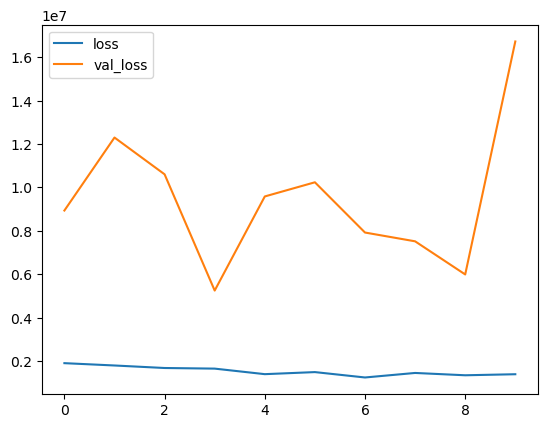

In [169]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

## Test Model

In [171]:
y_pred = model.predict([X_test_num, X_test_text])

13/13 [==============================] - 1s 9ms/step


In [174]:
y_pred = y_pred.reshape(-1)

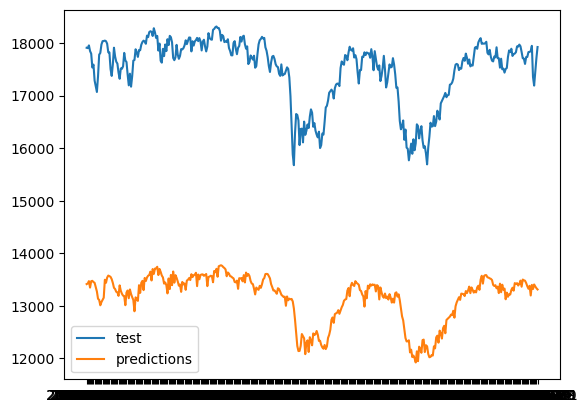

In [177]:
plt.plot(y_test, label = 'test')
plt.plot(y_pred, label = 'predictions')

plt.legend()
plt.show()